In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.mixture import GaussianMixture #For GMM clustering
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from keras import regularizers
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import metrics
plt.style.use('ggplot')
from matplotlib import style
%matplotlib inline

Using TensorFlow backend.


In [2]:
!pip install mlxtend

In [3]:
gpu_usage = pd.read_csv('sgemm_product.csv')
gpu_usage.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [4]:
remove_n = 0
df = pd.DataFrame(gpu_usage)
drop_indices = np.random.choice(df.index, remove_n, replace=False)
gpu_usage = df.drop(drop_indices)
gpu_usage.shape

(241600, 18)

In [5]:
gpu_usage_1=gpu_usage
gpu_usage_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 35.0 MB


In [6]:
#Calculate the average and setting the average_gpu_usage column
gpu_usage['average_gpu_runtime'] = gpu_usage[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis = 1)
gpu_usage.head(10)

gpu_usage_a = gpu_usage.drop(gpu_usage[(gpu_usage.average_gpu_runtime>2500)|(gpu_usage.average_gpu_runtime<0)].index)
gpu_usage_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241089 entries, 0 to 241599
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MWG                  241089 non-null  int64  
 1   NWG                  241089 non-null  int64  
 2   KWG                  241089 non-null  int64  
 3   MDIMC                241089 non-null  int64  
 4   NDIMC                241089 non-null  int64  
 5   MDIMA                241089 non-null  int64  
 6   NDIMB                241089 non-null  int64  
 7   KWI                  241089 non-null  int64  
 8   VWM                  241089 non-null  int64  
 9   VWN                  241089 non-null  int64  
 10  STRM                 241089 non-null  int64  
 11  STRN                 241089 non-null  int64  
 12  SA                   241089 non-null  int64  
 13  SB                   241089 non-null  int64  
 14  Run1 (ms)            241089 non-null  float64
 15  Run2 (ms)        

In [7]:
gpu_usage_a = gpu_usage_a.drop("Run1 (ms)", axis= 1)
gpu_usage_a = gpu_usage_a.drop("Run2 (ms)", axis= 1)
gpu_usage_a = gpu_usage_a.drop("Run3 (ms)", axis= 1)
gpu_usage_a = gpu_usage_a.drop("Run4 (ms)", axis= 1)
gpu_usage_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241089 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MWG                  241089 non-null  int64  
 1   NWG                  241089 non-null  int64  
 2   KWG                  241089 non-null  int64  
 3   MDIMC                241089 non-null  int64  
 4   NDIMC                241089 non-null  int64  
 5   MDIMA                241089 non-null  int64  
 6   NDIMB                241089 non-null  int64  
 7   KWI                  241089 non-null  int64  
 8   VWM                  241089 non-null  int64  
 9   VWN                  241089 non-null  int64  
 10  STRM                 241089 non-null  int64  
 11  STRN                 241089 non-null  int64  
 12  SA                   241089 non-null  int64  
 13  SB                   241089 non-null  int64  
 14  average_gpu_runtime  241089 non-null  float64
dtypes: float64(1), in

In [8]:
gpu_usage_a['average_gpu_runtime_Class'] = np.where(gpu_usage_a['average_gpu_runtime']>=70, 1, 0)
gpu_usage_a['average_gpu_runtime_Class'] = gpu_usage_a['average_gpu_runtime_Class'].astype('category')

In [9]:
gpu_usage_a = gpu_usage_a.drop("average_gpu_runtime", axis= 1)
df = gpu_usage_a

In [10]:
X, y = df.iloc[:, 0:14], gpu_usage_a.iloc[:,-1]
print(X.shape)
print(y.shape)

(241089, 14)
(241089,)


In [11]:
X.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0


In [12]:
X = pd.get_dummies(X,columns=X.columns,drop_first=True)
X.head()

,MWG_32,MWG_64,MWG_128,NWG_32,NWG_64,NWG_128,KWG_32,MDIMC_16,MDIMC_32,NDIMC_16,...,VWM_2,VWM_4,VWM_8,VWN_2,VWN_4,VWN_8,STRM_1,STRN_1,SA_1,SB_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
X.shape

(241089, 26)

In [14]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)
X_train.head()

,MWG_32,MWG_64,MWG_128,NWG_32,NWG_64,NWG_128,KWG_32,MDIMC_16,MDIMC_32,NDIMC_16,...,VWM_2,VWM_4,VWM_8,VWN_2,VWN_4,VWN_8,STRM_1,STRN_1,SA_1,SB_1
3712,0,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
27217,1,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4885,0,0,0,1,0,0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,1
63065,1,0,0,0,0,1,1,1,0,1,...,1,0,0,1,0,0,1,0,0,1
139426,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
df.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'average_gpu_runtime_Class'],
      dtype='object')

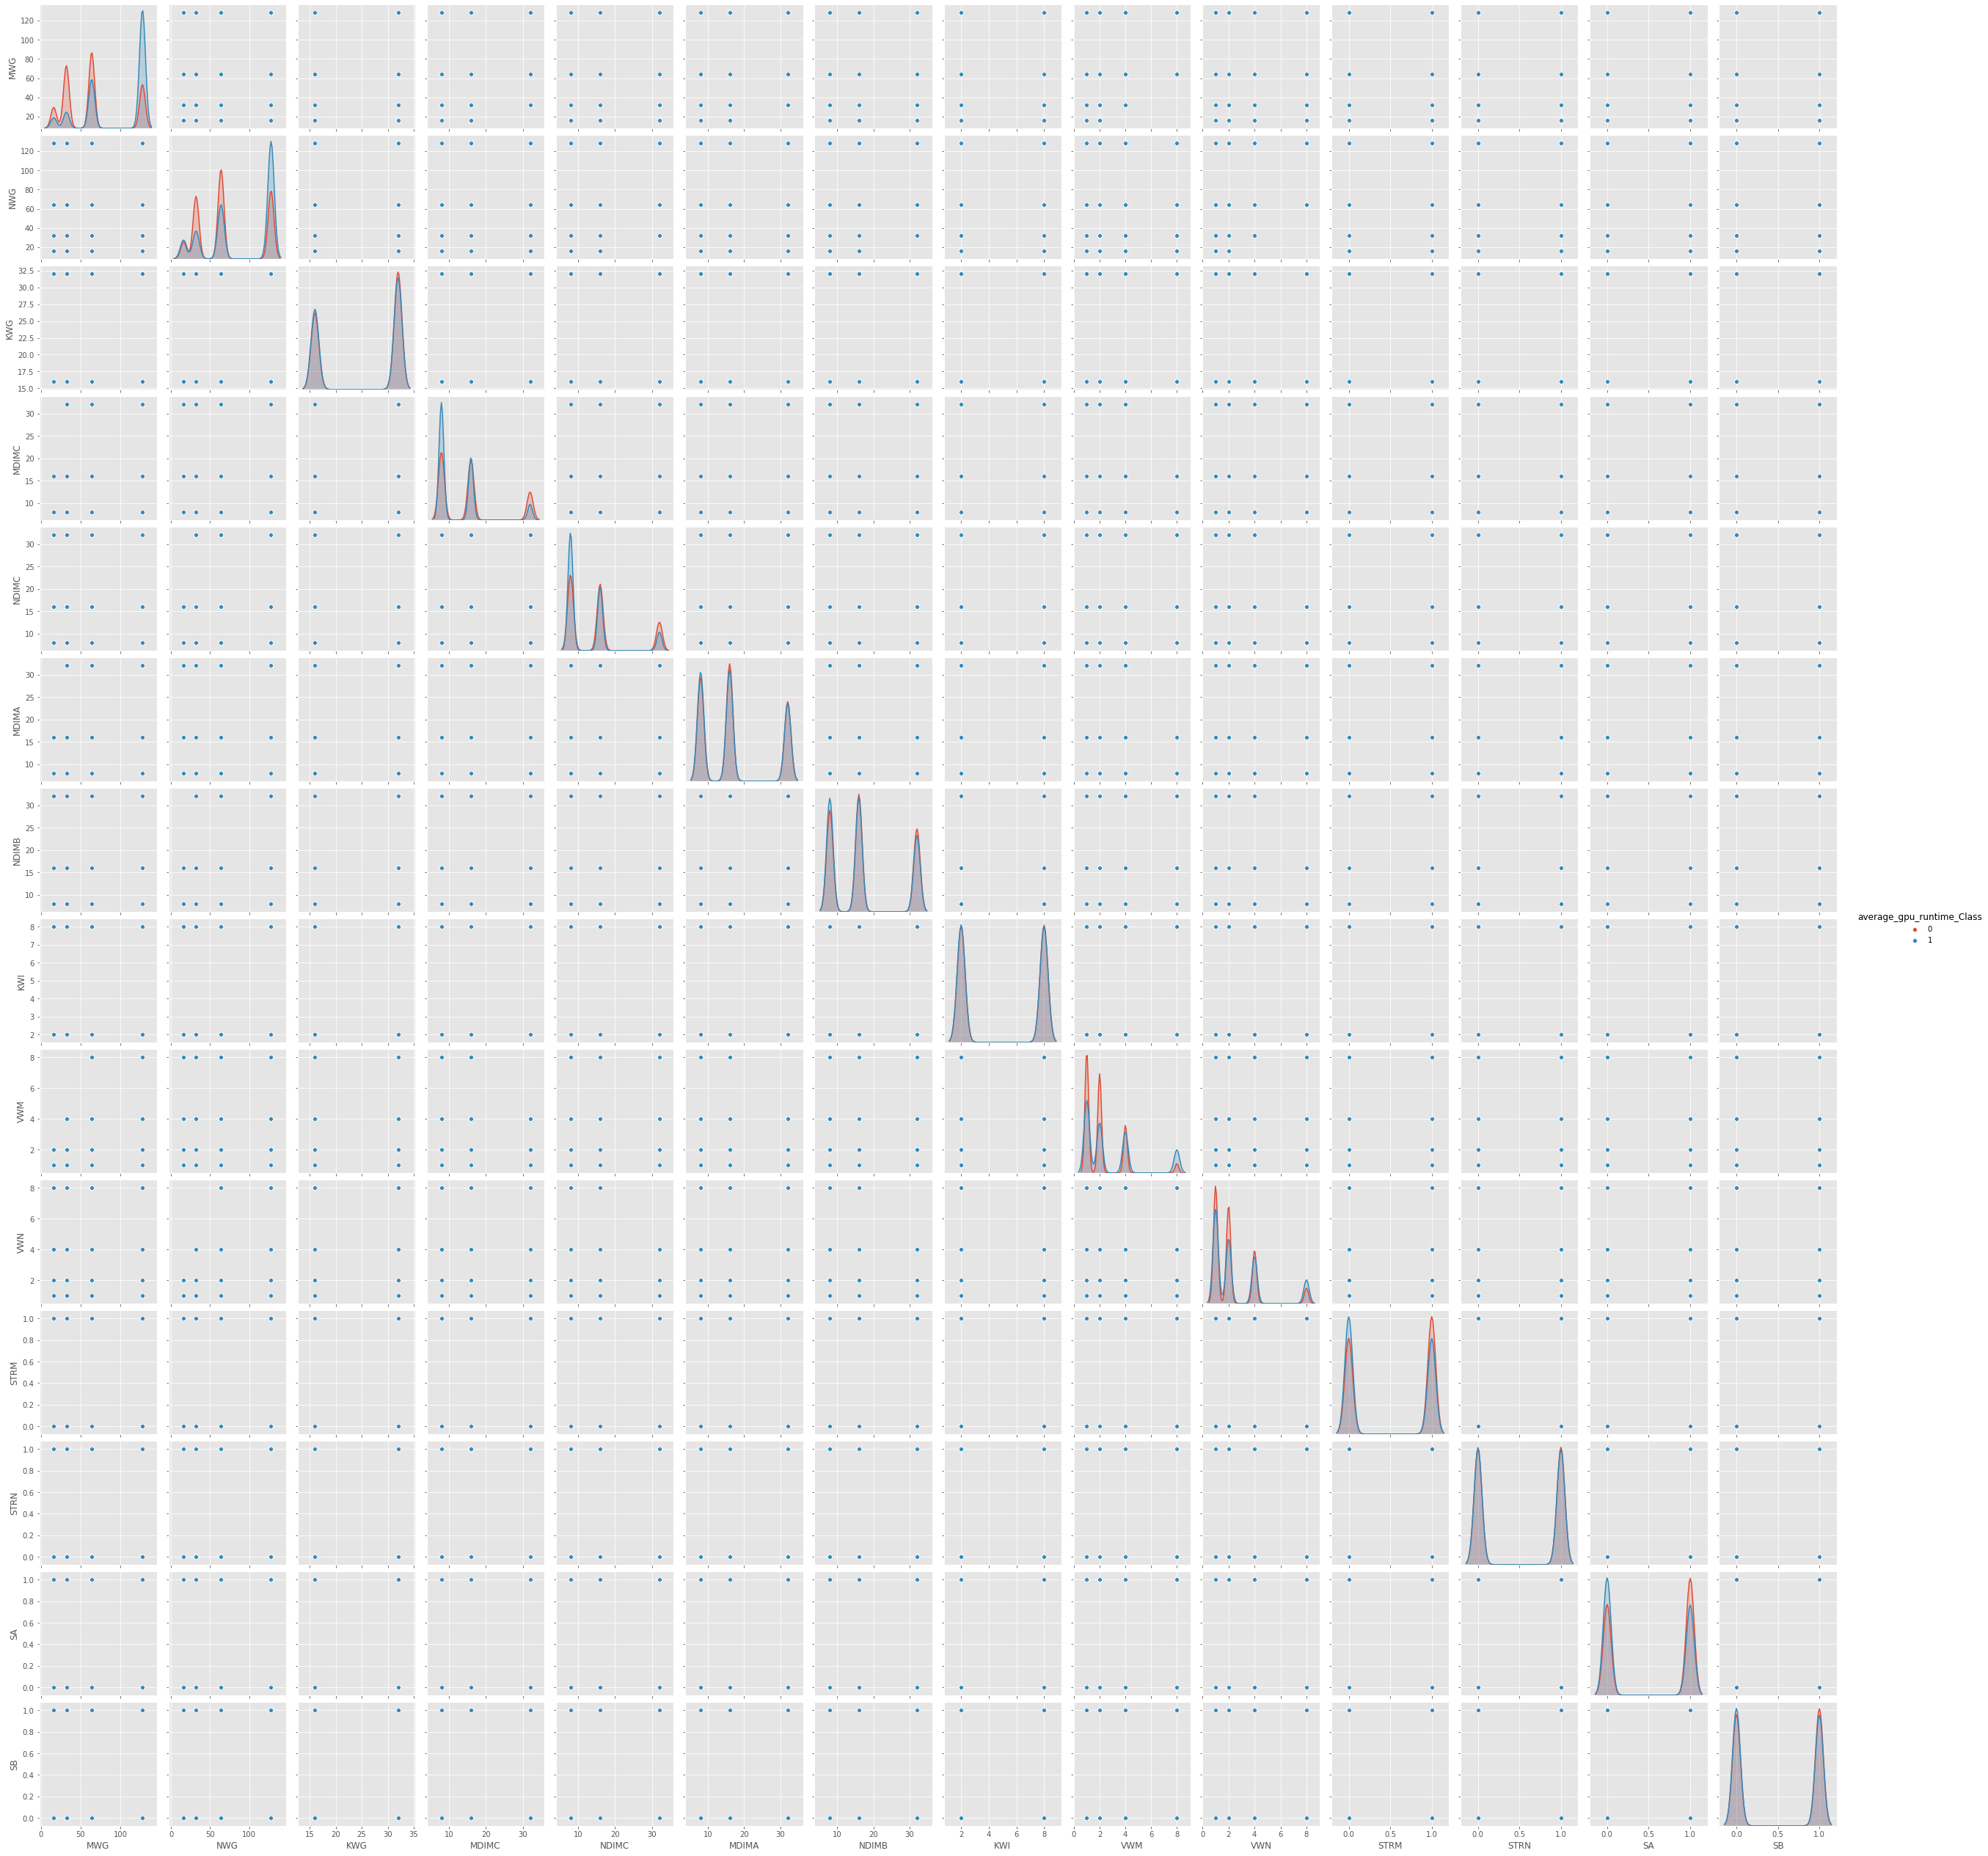

In [16]:
sns.pairplot(df[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN','STRM','STRN','SA','SB','average_gpu_runtime_Class']],hue='average_gpu_runtime_Class')

## Task 1 - k-means

In [17]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

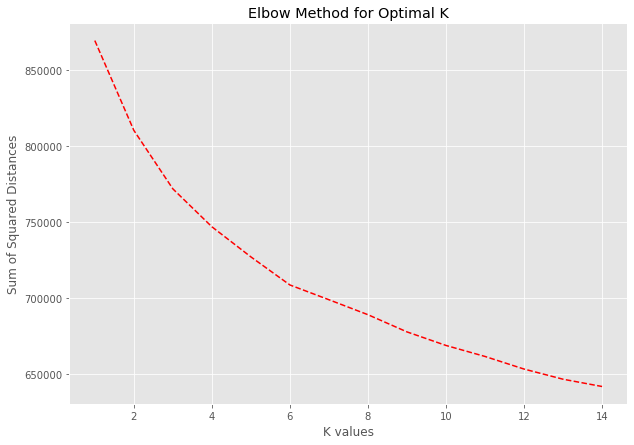

In [18]:
plt.figure(figsize=(10,7))
plt.title("Elbow Method for Optimal K")
plt.xlabel("K values")
plt.ylabel("Sum of Squared Distances")
plt.plot(K, Sum_of_squared_distances, color = 'red', linestyle = 'dashed')


In [19]:
model_k = KMeans(n_clusters=4, random_state=101)
model_k.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

In [20]:
# Validation prediction
prediction_v = model_k.predict(X_train)
prediction_k = model_k.predict(X_test)
(accuracy_score(y_test, prediction_k))*100

29.153704702255034

[[ 9070  2561 11084 13578]
 [11919 12016  3002  9097]
 [    0     0     0     0]
 [    0     0     0     0]]
              precision    recall  f1-score   support

           0       0.43      0.25      0.32     36293
           1       0.82      0.33      0.47     36034
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.29     72327
   macro avg       0.31      0.15      0.20     72327
weighted avg       0.63      0.29      0.40     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


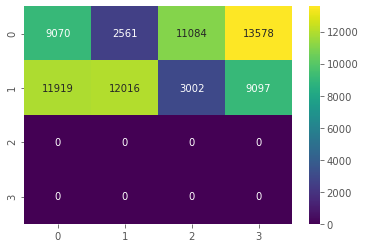

In [21]:
print(confusion_matrix(y_test,prediction_k))
print(classification_report(y_test,prediction_k))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,prediction_k)),annot=True,fmt="g",cmap='viridis'))

24.163022481364287
[[25956 11062 15715 32098]
 [16219 14822 31994 20896]
 [    0     0     0     0]
 [    0     0     0     0]]
              precision    recall  f1-score   support

           0       0.62      0.31      0.41     84831
           1       0.57      0.18      0.27     83931
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.24    168762
   macro avg       0.30      0.12      0.17    168762
weighted avg       0.59      0.24      0.34    168762



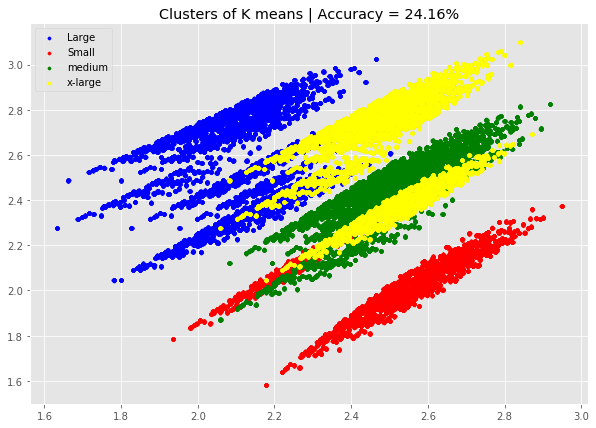

In [22]:
scaler = StandardScaler() 
kmeans_plot = KMeans(n_clusters=4,random_state=0)

X = kmeans_plot.fit_transform(X_train)
kmeans_plot.fit(X_train)
y_kmeans_2 = kmeans_plot.fit_predict(X_train)

acc= round(100*(accuracy_score(y_train,y_kmeans_2)),2)

print((accuracy_score(y_train,y_kmeans_2))*100)
print(confusion_matrix(y_train,y_kmeans_2))
print(classification_report(y_train,y_kmeans_2))

# Visualising the clusters
plt.figure(figsize=(10,7))
plt.scatter(X[y_kmeans_2 == 0, 0], X[y_kmeans_2 == 0, 1], s = 10, c = 'blue', label = 'Large')
plt.scatter(X[y_kmeans_2 == 1, 0], X[y_kmeans_2 == 1, 1], s = 10, c = 'red', label = 'Small')
plt.scatter(X[y_kmeans_2 == 2, 0], X[y_kmeans_2 == 2, 1], s = 10, c = 'green', label = 'medium')
plt.scatter(X[y_kmeans_2 == 3, 0], X[y_kmeans_2 == 3, 1], s = 10, c = 'yellow', label = 'x-large')
#plt.scatter(X[y_kmeans_2 == 4, 0], X[y_kmeans_2 == 4, 1], s = 10, c = 'black', label = 'xx-large')
plt.title("Clusters of K means | Accuracy = {}%".format(acc))
plt.xlabel("")
plt.ylabel("")
plt.legend()


In [23]:
X

array([[1.8359873 , 2.39082988, 2.36918363, 2.33094014],
       [2.17457187, 2.6832232 , 2.53805471, 2.56430063],
       [1.91794676, 2.49376205, 2.43441762, 2.36808573],
       ...,
       [2.12160575, 2.43638496, 2.25458002, 2.21600869],
       [2.47391883, 2.72031605, 2.59601552, 2.1716859 ],
       [2.74106652, 2.21883359, 2.52335338, 2.79263903]])

## GMM

[[60481 24350]
 [38782 45149]]
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     84831
           1       0.65      0.54      0.59     83931

    accuracy                           0.63    168762
   macro avg       0.63      0.63      0.62    168762
weighted avg       0.63      0.63      0.62    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


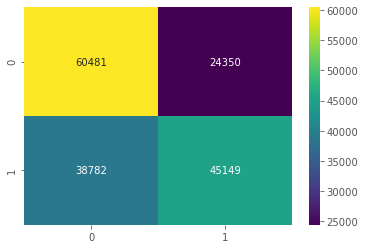

In [24]:
Gaussian = GaussianMixture(n_components=2,random_state=0)#covariance_type='tied')
Gaussian.fit(X_train)
predictions = Gaussian.predict(X_train)
probs = Gaussian.predict_proba(X_train)
print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_train,predictions)),annot=True,fmt="g",cmap='viridis'))


In [25]:
acc= round(100*accuracy_score(y_train,predictions),2)
print(acc)

62.59


62.41
[[25817 10476]
 [16712 19322]]
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     36293
           1       0.65      0.54      0.59     36034

    accuracy                           0.62     72327
   macro avg       0.63      0.62      0.62     72327
weighted avg       0.63      0.62      0.62     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


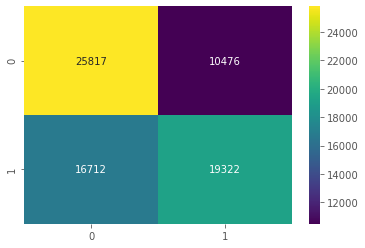

In [26]:
def GMM_def(X_train, n = 2):
    Gaussian1 = GaussianMixture(n_components=n,random_state=10)
    Gaussian1.fit(X_test)
    predictions1 = Gaussian1.predict(X_test)
    probs = Gaussian.predict_proba(X_test)
    print(round(100*accuracy_score(y_test,predictions1),2))
    print(confusion_matrix(y_test,predictions1))
    print(classification_report(y_test,predictions1))

    print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,predictions1)),annot=True,fmt="g",cmap='viridis'))


GMM_def(X_test)

## Task - 2

In [27]:
estimator = ExtraTreesClassifier(n_estimators = 100)
featureSelection = SelectFromModel(estimator)
featureSelection.fit(X_train, y_train)
selectedFeatures = featureSelection.transform(X_train)
selectedFeatures

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 1, 0]], dtype=uint8)

In [28]:
X_train.columns[featureSelection.get_support()]

Index(['MWG_32', 'MWG_64', 'MWG_128', 'NWG_32', 'NWG_64', 'NWG_128',
       'MDIMC_16', 'MDIMC_32', 'NDIMC_16', 'NDIMC_32', 'STRM_1', 'SA_1'],
      dtype='object')

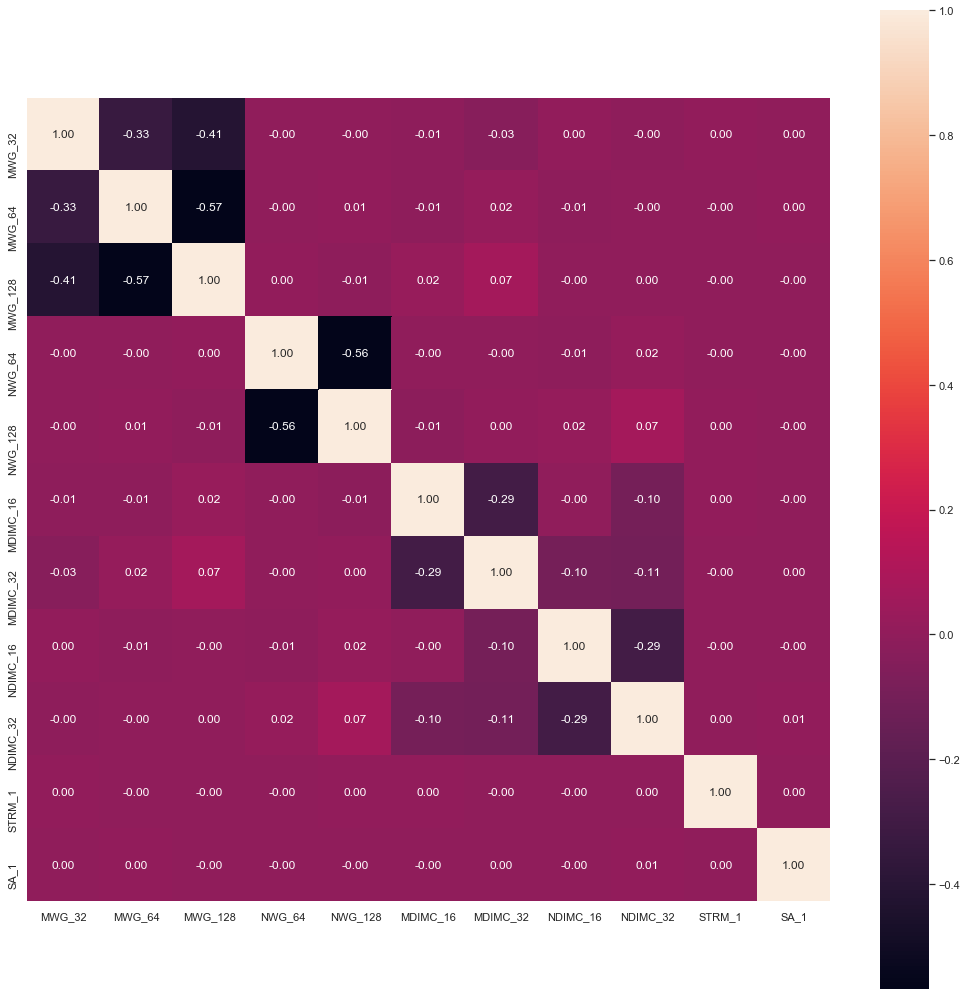

In [29]:
#print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(selectedFeatures,featureSelection.get_support())),annot=True,fmt="g",cmap='viridis'))
#Ploting correlation matrix

feature_selected_X_te = X_test.loc[:,['MWG_32', 'MWG_64', 'MWG_128', 'NWG_64', 'NWG_128', 'MDIMC_16',
       'MDIMC_32', 'NDIMC_16', 'NDIMC_32', 'STRM_1', 'SA_1']]

corr = feature_selected_X_te.corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels='auto', yticklabels='auto')
plt.show();





# Based on these results from feature selection lets use above features and check the accuracy

In [30]:
feature_selected_X_train = X_train.loc[:,['MWG_32', 'MWG_128', 'NWG_64', 'NWG_128', 'MDIMC_16', 'MDIMC_32',
       'NDIMC_16', 'NDIMC_32', 'STRM_1', 'SA_1']]

In [31]:
feature_selected_X_train.head()

,MWG_32,MWG_128,NWG_64,NWG_128,MDIMC_16,MDIMC_32,NDIMC_16,NDIMC_32,STRM_1,SA_1
3712,0,0,0,0,0,0,1,0,0,0
27217,1,0,0,0,0,0,0,0,0,0
4885,0,0,0,0,1,0,1,0,0,0
63065,1,0,0,1,1,0,1,0,1,0
139426,0,0,0,1,0,1,0,0,0,1


In [32]:
feature_selected_X_test = X_test.loc[:,['MWG_32', 'MWG_128', 'NWG_64', 'NWG_128', 'MDIMC_16', 'MDIMC_32',
       'NDIMC_16', 'NDIMC_32', 'STRM_1', 'SA_1']]

In [33]:
model_feature = KMeans(n_clusters=4, random_state=101)
model_feature.fit(feature_selected_X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

16.45216340171366
              precision    recall  f1-score   support

           0       0.32      0.17      0.22     84831
           1       0.32      0.16      0.21     83931
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.16    168762
   macro avg       0.16      0.08      0.11    168762
weighted avg       0.32      0.16      0.22    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


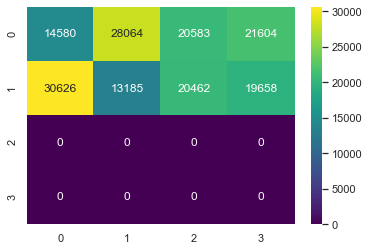

In [34]:
# VALIDATION
prediction_feature_valid = model_feature.predict(feature_selected_X_train)
valid_feature = accuracy_score(y_train, prediction_feature_valid)
print((accuracy_score(y_train, prediction_feature_valid))*100)
print(classification_report(y_train, prediction_feature_valid))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_train,prediction_feature_valid)),annot=True,fmt="g",cmap='viridis'))

16.453053493162994
              precision    recall  f1-score   support

           0       0.32      0.17      0.22     36293
           1       0.32      0.16      0.21     36034
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.16     72327
   macro avg       0.16      0.08      0.11     72327
weighted avg       0.32      0.16      0.22     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


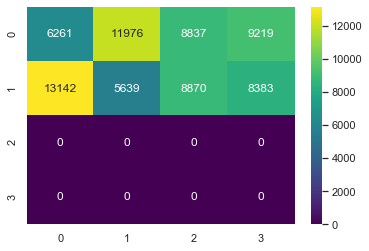

In [35]:
# TEST RESULTS
prediction_feature_test = model_feature.predict(feature_selected_X_test)
test_feature = accuracy_score(y_test, prediction_feature_test)
print((accuracy_score(y_test, prediction_feature_test))*100)
print(classification_report(y_test, prediction_feature_test))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,prediction_feature_test)),annot=True,fmt="g",cmap='viridis'))

62.59110463255946
[[60481 24350]
 [38782 45149]]
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     84831
           1       0.65      0.54      0.59     83931

    accuracy                           0.63    168762
   macro avg       0.63      0.63      0.62    168762
weighted avg       0.63      0.63      0.62    168762



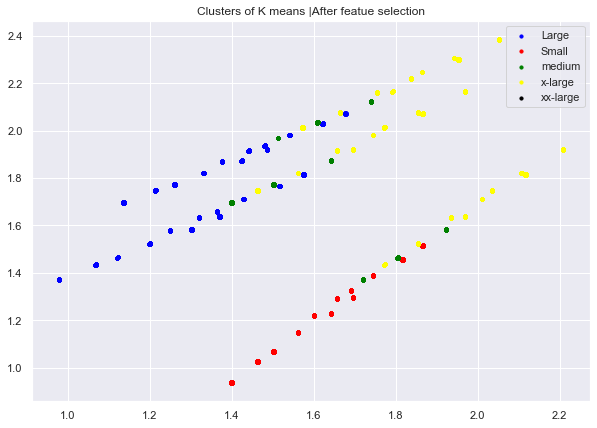

In [74]:
kmeans_plot = KMeans(n_clusters=4,random_state=0)

X = kmeans_plot.fit_transform(feature_selected_X_train)
kmeans_plot.fit(feature_selected_X_train)
y_kmeans_2 = kmeans_plot.fit_predict(feature_selected_X_train)

acc= round(100*(accuracy_score(y_train,y_kmeans_2)),2)

print((accuracy_score(y_train,predictions))*100)
print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))

# Visualising the clusters
plt.figure(figsize=(10,7))
plt.scatter(X[y_kmeans_2 == 0, 0], X[y_kmeans_2 == 0, 1], s = 10, c = 'blue', label = 'Large')
plt.scatter(X[y_kmeans_2 == 1, 0], X[y_kmeans_2 == 1, 1], s = 10, c = 'red', label = 'Small')
plt.scatter(X[y_kmeans_2 == 2, 0], X[y_kmeans_2 == 2, 1], s = 10, c = 'green', label = 'medium')
plt.scatter(X[y_kmeans_2 == 3, 0], X[y_kmeans_2 == 3, 1], s = 10, c = 'yellow', label = 'x-large')
plt.scatter(X[y_kmeans_2 == 4, 0], X[y_kmeans_2 == 4, 1], s = 10, c = 'black', label = 'xx-large')
plt.title("Clusters of K means |After featue selection")
plt.xlabel('')
plt.ylabel("")
plt.legend()


## Expectation maximization after feature selection

[[32098 52733]
 [20896 63035]]
              precision    recall  f1-score   support

           0       0.61      0.38      0.47     84831
           1       0.54      0.75      0.63     83931

    accuracy                           0.56    168762
   macro avg       0.58      0.56      0.55    168762
weighted avg       0.58      0.56      0.55    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


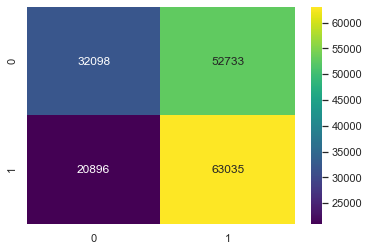

In [38]:
GaussianFS = GaussianMixture(n_components=2,random_state=0)#covariance_type='tied')
GaussianFS.fit(feature_selected_X_train)
predictionsFS = GaussianFS.predict(feature_selected_X_train)
probsFS = GaussianFS.predict_proba(feature_selected_X_train)
print(confusion_matrix(y_train,predictionsFS))
print(classification_report(y_train,predictionsFS))

print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_train,predictionsFS)),annot=True,fmt="g",cmap='viridis'))


In [39]:
acc= round(100*accuracy_score(y_train,predictions),2)
print(acc)


62.59


39.0
[[25209 11084]
 [33032  3002]]
              precision    recall  f1-score   support

           0       0.43      0.69      0.53     36293
           1       0.21      0.08      0.12     36034

    accuracy                           0.39     72327
   macro avg       0.32      0.39      0.33     72327
weighted avg       0.32      0.39      0.33     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


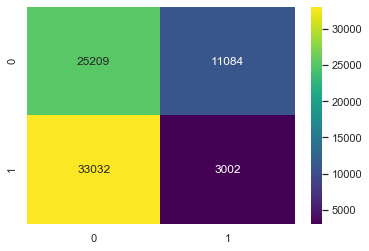

In [40]:
def GMM_def(X_train, n = 2):
    Gaussian1FS = GaussianMixture(n_components=n,random_state=10)
    Gaussian1FS.fit(feature_selected_X_test)
    predictions1FS = Gaussian1FS.predict(feature_selected_X_test)
    probsFS = GaussianFS.predict_proba(feature_selected_X_test)
    print(round(100*accuracy_score(y_test,predictions1FS),2))
    print(confusion_matrix(y_test,predictions1FS))
    print(classification_report(y_test,predictions1FS))

    print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,predictions1FS)),annot=True,fmt="g",cmap='viridis'))


GMM_def(feature_selected_X_test)

## PCA = 25

In [41]:
pca = PCA(n_components=25)

pca_X_train = pd.DataFrame(pca.fit_transform(X_train))
pca_X_test = pd.DataFrame(pca.transform(X_test))

## PCA - 2

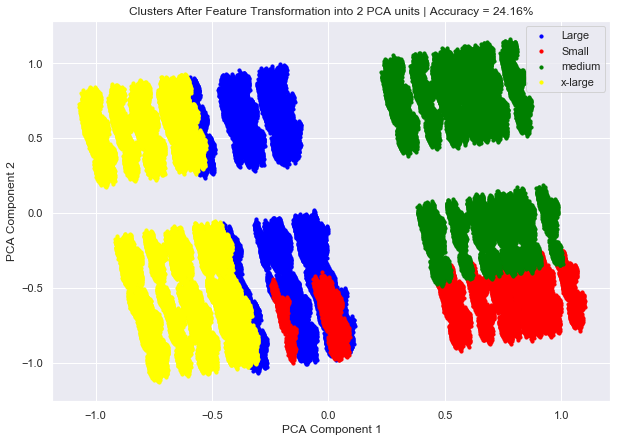

In [42]:
kmeans_plot = KMeans(n_clusters=4,random_state=0)

pca_2 = PCA(n_components=4)

X = pca_2.fit_transform(X_train)

kmeans_plot.fit(X_train)
y_kmeans_2 = kmeans_plot.fit_predict(X_train)

acc= round(100*(accuracy_score(y_train,y_kmeans_2)),2)

# Visualising the clusters
plt.figure(figsize=(10,7))
plt.scatter(X[y_kmeans_2 == 0, 0], X[y_kmeans_2 == 0, 1], s = 10, c = 'blue', label = 'Large')
plt.scatter(X[y_kmeans_2 == 1, 0], X[y_kmeans_2 == 1, 1], s = 10, c = 'red', label = 'Small')
plt.scatter(X[y_kmeans_2 == 2, 0], X[y_kmeans_2 == 2, 1], s = 10, c = 'green', label = 'medium')
plt.scatter(X[y_kmeans_2 == 3, 0], X[y_kmeans_2 == 3, 1], s = 10, c = 'yellow', label = 'x-large')
#plt.scatter(X[y_kmeans_2 == 4, 0], X[y_kmeans_2 == 4, 1], s = 10, c = 'black', label = 'xx-large')
plt.title("Clusters After Feature Transformation into 2 PCA units | Accuracy = {}%".format(acc))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.savefig("ClusterSeperation.png")

23.991775399675284
              precision    recall  f1-score   support

           0       0.33      0.19      0.24     84831
           1       0.61      0.30      0.40     83931
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.24    168762
   macro avg       0.23      0.12      0.16    168762
weighted avg       0.47      0.24      0.32    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


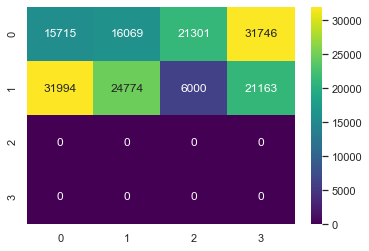

In [43]:
model_pca = KMeans(n_clusters=4, random_state=100)
model_pca.fit(pca_X_train)
# VALIDATION
prediction_pca_valid = model_pca.predict(pca_X_train)
valid_pca = accuracy_score(y_train, prediction_pca_valid)
print(accuracy_score(y_train, prediction_pca_valid)*100)
print(classification_report(y_train, prediction_pca_valid))

print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_train,prediction_pca_valid)),annot=True,fmt="g",cmap='viridis'))


24.01454505233177
              precision    recall  f1-score   support

           0       0.33      0.18      0.24     36293
           1       0.60      0.30      0.40     36034
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.24     72327
   macro avg       0.23      0.12      0.16     72327
weighted avg       0.47      0.24      0.32     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


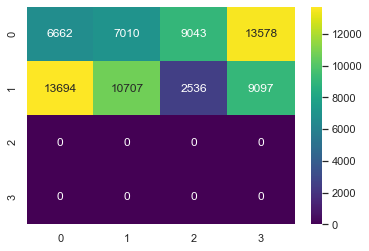

In [44]:
# TEST RESULTS
prediction_pca_test = model_pca.predict(pca_X_test)
test_pca = accuracy_score(y_test, prediction_pca_test)
print(accuracy_score(y_test, prediction_pca_test)*100)
print(classification_report(y_test, prediction_pca_test))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,prediction_pca_test)),annot=True,fmt="g",cmap='viridis'))

In [45]:
## PCA Expectation maximization
#gmm_acc = GMM_def(pca_X_train, 2)
#print(gmm_acc)
Gaussian1FS = GaussianMixture(n_components=2,random_state=10)
Gaussian1FS.fit(pca_X_train)
predictions1FS = Gaussian1FS.predict(pca_X_train)
#probsFS = GaussianFS.predict_proba(pca_X_train)
print(round(100*accuracy_score(y_train,predictions1FS),2))
print(confusion_matrix(y_train,predictions1FS))
print(classification_report(y_train,predictions1FS))




49.18
[[51577 33254]
 [52519 31412]]
              precision    recall  f1-score   support

           0       0.50      0.61      0.55     84831
           1       0.49      0.37      0.42     83931

    accuracy                           0.49    168762
   macro avg       0.49      0.49      0.48    168762
weighted avg       0.49      0.49      0.48    168762



In [46]:
Gaussian1FS = GaussianMixture(n_components=2,random_state=10)
Gaussian1FS.fit(pca_X_test)
predictions1FS = Gaussian1FS.predict(pca_X_test)
#probsFS = GaussianFS.predict_proba(pca_X_test)
print(round(100*accuracy_score(y_test,predictions1FS),2))
print(confusion_matrix(y_test,predictions1FS))
print(classification_report(y_test,predictions1FS))


30.32
[[ 7916 28377]
 [22018 14016]]
              precision    recall  f1-score   support

           0       0.26      0.22      0.24     36293
           1       0.33      0.39      0.36     36034

    accuracy                           0.30     72327
   macro avg       0.30      0.30      0.30     72327
weighted avg       0.30      0.30      0.30     72327



# Behavior of K-Means by runnning it few times

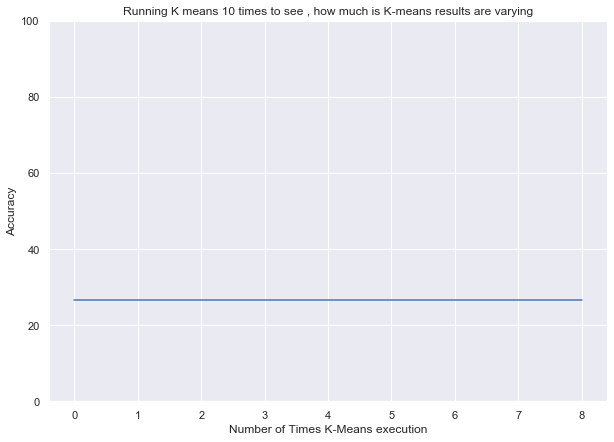

In [47]:
acc_k = []
for i in range(1,10):

    kmeans_multi = KMeans(n_clusters=4,random_state=101)
    kmeans_multi.fit(pca_X_train)

    predictions_multi = kmeans_multi.predict(pca_X_train)
    acc1= round(100*accuracy_score(y_train,predictions_multi),2)

    acc_k.append(acc1)
    
plt.figure(figsize=(10,7))
plt.plot(acc_k)
plt.ylabel("Accuracy")
plt.title("Running K means 10 times to see , how much is K-means results are varying")
plt.xlabel("Number of Times K-Means execution")
plt.ylim(0,100)
plt.show()

## ICA

In [48]:
ica = FastICA(n_components=25)

ica_X_train = pd.DataFrame(ica.fit_transform(X_train))
ica_X_test = pd.DataFrame(ica.transform(X_test))

17.783624275607067
              precision    recall  f1-score   support

           0       0.69      0.18      0.28     84831
           1       0.56      0.18      0.27     83931
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.18    168762
   macro avg       0.25      0.07      0.11    168762
weighted avg       0.63      0.18      0.28    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


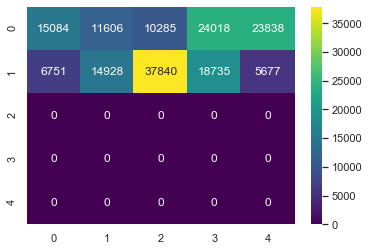

In [49]:
model_ica = KMeans(n_clusters=5, random_state=100)
model_ica.fit(ica_X_train)
# VALIDATION
prediction_ica_valid = model_ica.predict(ica_X_train)
valid_ica = accuracy_score(y_train, prediction_ica_valid)
print(accuracy_score(y_train, prediction_ica_valid)*100)
print(classification_report(y_train, prediction_ica_valid))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_train,prediction_ica_valid)),annot=True,fmt="g",cmap='viridis'))


17.884054364207007
              precision    recall  f1-score   support

           0       0.69      0.18      0.29     36293
           1       0.57      0.18      0.27     36034
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.18     72327
   macro avg       0.25      0.07      0.11     72327
weighted avg       0.63      0.18      0.28     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


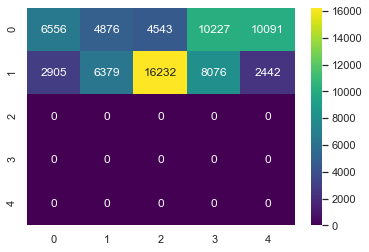

In [50]:
# TEST RESULTS
prediction_ica_test = model_ica.predict(ica_X_test)
test_ica = accuracy_score(y_test, prediction_ica_test)
print(accuracy_score(y_test, prediction_ica_test)*100)
print(classification_report(y_test, prediction_ica_test))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,prediction_ica_test)),annot=True,fmt="g",cmap='viridis'))

In [51]:
#ica_acc = GMM_def(ica_X_train,2)
#print(ica_acc)
Gaussian1FS = GaussianMixture(n_components=2,random_state=10)
Gaussian1FS.fit(ica_X_train)
predictions1FS = Gaussian1FS.predict(ica_X_train)
#probsFS = GaussianFS.predict_proba(pca_X_test)
print(round(100*accuracy_score(y_train,predictions1FS),2))
print(confusion_matrix(y_train,predictions1FS))
print(classification_report(y_train,predictions1FS))


51.91
[[18448 66383]
 [14771 69160]]
              precision    recall  f1-score   support

           0       0.56      0.22      0.31     84831
           1       0.51      0.82      0.63     83931

    accuracy                           0.52    168762
   macro avg       0.53      0.52      0.47    168762
weighted avg       0.53      0.52      0.47    168762



In [52]:
#ica_acc = GMM_def(ica_X_train,2)
#print(ica_acc)
Gaussian1FS = GaussianMixture(n_components=2,random_state=10)
Gaussian1FS.fit(ica_X_test)
predictions1FS = Gaussian1FS.predict(ica_X_test)
#probsFS = GaussianFS.predict_proba(pca_X_test)
print(round(100*accuracy_score(y_test,predictions1FS),2))
print(confusion_matrix(y_test,predictions1FS))
print(classification_report(y_test,predictions1FS))


49.94
[[15058 21235]
 [14971 21063]]
              precision    recall  f1-score   support

           0       0.50      0.41      0.45     36293
           1       0.50      0.58      0.54     36034

    accuracy                           0.50     72327
   macro avg       0.50      0.50      0.50     72327
weighted avg       0.50      0.50      0.50     72327



## Randomized projection

In [53]:
grp = GaussianRandomProjection(n_components=85, eps=0.1, random_state=420)
rca_X_train = pd.DataFrame(grp.fit_transform(X_train))
rca_X_test = pd.DataFrame(grp.transform(X_test))

9.601095033242082
              precision    recall  f1-score   support

           0       0.19      0.08      0.12     84831
           1       0.34      0.11      0.16     83931
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.10    168762
   macro avg       0.11      0.04      0.06    168762
weighted avg       0.26      0.10      0.14    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


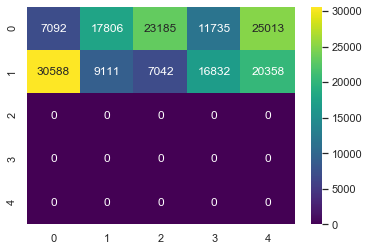

In [54]:
model_rca = KMeans(n_clusters=5, random_state=99)
model_rca.fit(rca_X_train)
# VALIDATION
prediction_rca_valid = model_rca.predict(rca_X_train)
valid_rca = accuracy_score(y_train, prediction_rca_valid)
print(accuracy_score(y_train, prediction_rca_valid)*100)
print(classification_report(y_train, prediction_rca_valid))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_train,prediction_rca_valid)),annot=True,fmt="g",cmap='viridis'))


9.52064927343869
              precision    recall  f1-score   support

           0       0.19      0.09      0.12     36293
           1       0.33      0.10      0.16     36034
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.10     72327
   macro avg       0.10      0.04      0.06     72327
weighted avg       0.26      0.10      0.14     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


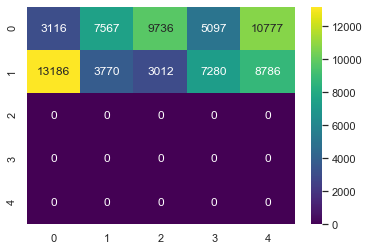

In [55]:

# TEST RESULTS
prediction_rca_test = model_rca.predict(rca_X_test)
test_rca = accuracy_score(y_test, prediction_rca_test)
print(accuracy_score(y_test, prediction_rca_test)*100)
print(classification_report(y_test, prediction_rca_test))
print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,prediction_rca_test)),annot=True,fmt="g",cmap='viridis'))

In [56]:
#rca_acc = GMM_def(rca_X_train,2)
#print(rca_acc)

Gaussian1FS = GaussianMixture(n_components=2,random_state=10)
Gaussian1FS.fit(rca_X_train)
predictions1FS = Gaussian1FS.predict(rca_X_train)
#probsFS = GaussianFS.predict_proba(pca_X_test)
print(round(100*accuracy_score(y_train,predictions1FS),2))
print(confusion_matrix(y_train,predictions1FS))
print(classification_report(y_train,predictions1FS))


30.1
[[18114 66717]
 [51249 32682]]
              precision    recall  f1-score   support

           0       0.26      0.21      0.23     84831
           1       0.33      0.39      0.36     83931

    accuracy                           0.30    168762
   macro avg       0.29      0.30      0.30    168762
weighted avg       0.29      0.30      0.30    168762



In [57]:
#ica_acc = GMM_def(ica_X_train,2)
#print(ica_acc)
Gaussian1FS = GaussianMixture(n_components=2,random_state=10)
Gaussian1FS.fit(rca_X_test)
predictions1FS = Gaussian1FS.predict(rca_X_test)
#probsFS = GaussianFS.predict_proba(pca_X_test)
print(round(100*accuracy_score(y_test,predictions1FS),2))
print(confusion_matrix(y_test,predictions1FS))
print(classification_report(y_test,predictions1FS))


30.32
[[ 7916 28377]
 [22018 14016]]
              precision    recall  f1-score   support

           0       0.26      0.22      0.24     36293
           1       0.33      0.39      0.36     36034

    accuracy                           0.30     72327
   macro avg       0.30      0.30      0.30     72327
weighted avg       0.30      0.30      0.30     72327



In [58]:
validation_scores = [valid_feature, valid_pca, valid_ica, valid_rca]
test_scores = [test_feature, test_pca, test_ica, test_rca]

In [59]:
test_scores

[0.16453053493162995,
 0.2401454505233177,
 0.17884054364207005,
 0.09520649273438689]

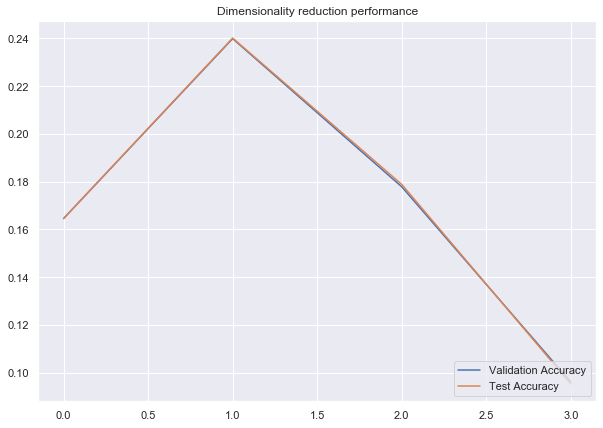

In [60]:
plt.figure(figsize=(10,7))
plt.title("Dimensionality reduction performance")
#plt.xticks('Feature','ICA','PCA','RCA')
plt.plot(validation_scores, label = 'Validation Accuracy')
plt.plot(test_scores, label="Test Accuracy")
plt.legend(loc = "lower right")

## Neural network

In [61]:
classifier = Sequential()

classifier.add(Dense(14, activation= 'relu', input_dim =85))
classifier.add(Dense(7, activation= 'tanh'))
classifier.add(Dense(5, activation= 'tanh'))
classifier.add(Dense(1, activation= 'sigmoid'))
classifier.compile(optimizer= 'adam',loss='binary_crossentropy', metrics=['accuracy'])
hist = classifier.fit(rca_X_train, y_train, batch_size = 10, epochs = 10, validation_data=(rca_X_test,y_test))

Train on 168762 samples, validate on 72327 samples
Epoch 1/10
168762/168762 [==============================] - 52s 306us/step - loss: 0.2139 - accuracy: 0.9136 - val_loss: 0.1483 - val_accuracy: 0.9375
Epoch 2/10
168762/168762 [==============================] - 50s 297us/step - loss: 0.1198 - accuracy: 0.9514 - val_loss: 0.1023 - val_accuracy: 0.9599
Epoch 3/10
168762/168762 [==============================] - 50s 294us/step - loss: 0.1014 - accuracy: 0.9586 - val_loss: 0.0944 - val_accuracy: 0.9616
Epoch 4/10
168762/168762 [==============================] - 48s 284us/step - loss: 0.0935 - accuracy: 0.9614 - val_loss: 0.0924 - val_accuracy: 0.9603
Epoch 5/10
168762/168762 [==============================] - 51s 303us/step - loss: 0.0876 - accuracy: 0.9643 - val_loss: 0.0837 - val_accuracy: 0.9654
Epoch 6/10
168762/168762 [==============================] - 49s 289us/step - loss: 0.0846 - accuracy: 0.9654 - val_loss: 0.0770 - val_accuracy: 0.9685
Epoch 7/10
168762/168762 [=================

In [62]:
y_pred_relu = classifier.predict(rca_X_train)
y_pred_relu = y_pred_relu > 0.5
print(accuracy_score(y_train,y_pred_relu)*100)
print(classification_report(y_train,y_pred_relu))


96.93532904326804
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     84831
           1       0.99      0.95      0.97     83931

    accuracy                           0.97    168762
   macro avg       0.97      0.97      0.97    168762
weighted avg       0.97      0.97      0.97    168762



96.84626764555422
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     36293
           1       0.99      0.95      0.97     36034

    accuracy                           0.97     72327
   macro avg       0.97      0.97      0.97     72327
weighted avg       0.97      0.97      0.97     72327

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


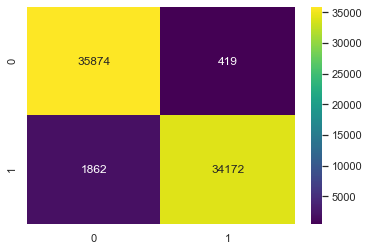

In [63]:
y_pred_relu = classifier.predict(rca_X_test)
y_pred_relu = y_pred_relu > 0.5
print(accuracy_score(y_test,y_pred_relu)*100)
print(classification_report(y_test,y_pred_relu))

print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred_relu)),annot=True,fmt="g",cmap='viridis'))

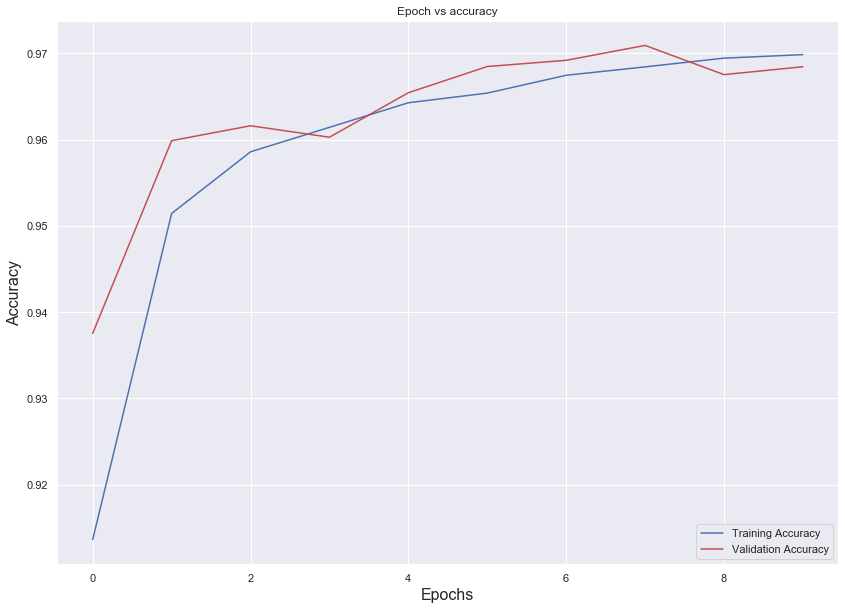

In [64]:
plt.figure(figsize=(14,10))
plt.title("Epoch vs accuracy")
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(hist.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## Task -5 

In [65]:
new_Df = pd.DataFrame()
data = pd.DataFrame({"KM_Pred": prediction_v,"EM_Prob": probs[:,1],"ActualOutput": y_train})
new_Df = new_Df.append(data)

new_Df.head()

,KM_Pred,EM_Prob,ActualOutput
3712,0,0.0,0
27217,2,0.0,0
4885,0,0.0,0
63065,2,1.0,0
139426,3,1.0,0


In [66]:
X_train_5 = new_Df.iloc[:, 0:2]
y_5 = new_Df.iloc[:, 2:]

In [67]:
NNclassifier = Sequential()

# Adding the input layer and the first hidden layer
NNclassifier.add(Dense(18, init = 'uniform', activation = 'relu', input_dim = 2))

# Adding the second hidden layer
NNclassifier.add(Dense(9, init = 'uniform', activation = 'relu'))

# Adding the output layer
NNclassifier.add(Dense(1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
NNclassifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
NNclassifier.fit(X_train_5, y_5, batch_size = 10, nb_epoch = 10)

Epoch 1/10
168762/168762 [==============================] - 33s 195us/step - loss: 0.6285 - accuracy: 0.6640
Epoch 2/10
168762/168762 [==============================] - 33s 193us/step - loss: 0.6157 - accuracy: 0.6675
Epoch 3/10
168762/168762 [==============================] - 33s 196us/step - loss: 0.5879 - accuracy: 0.6943
Epoch 4/10
168762/168762 [==============================] - 33s 197us/step - loss: 0.5828 - accuracy: 0.7007
Epoch 5/10
168762/168762 [==============================] - 33s 197us/step - loss: 0.5821 - accuracy: 0.7007
Epoch 6/10
168762/168762 [==============================] - 35s 205us/step - loss: 0.5820 - accuracy: 0.7009
Epoch 7/10
168762/168762 [==============================] - 35s 205us/step - loss: 0.5818 - accuracy: 0.7011
Epoch 8/10
168762/168762 [==============================] - 33s 193us/step - loss: 0.5816 - accuracy: 0.7010
Epoch 9/10
168762/168762 [==============================] - 35s 208us/step - loss: 0.5816 - accuracy: 0.7010
Epoch 10/10
168762/

70.10938481411692
[[49342 35489]
 [14955 68976]]
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     84831
           1       0.66      0.82      0.73     83931

    accuracy                           0.70    168762
   macro avg       0.71      0.70      0.70    168762
weighted avg       0.71      0.70      0.70    168762

Confusion matrix

 AxesSubplot(0.125,0.125;0.62x0.755)


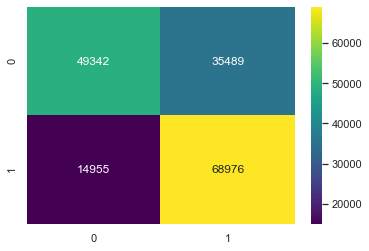

In [68]:
y_pred_5 = NNclassifier.predict(X_train_5)
y_pred_5 = y_pred_5 > 0.5
print(accuracy_score(y_5,y_pred_5)*100)
print(confusion_matrix(y_5,y_pred_5))
print(classification_report(y_5,y_pred_5))

print('Confusion matrix\n\n', sns.heatmap(pd.DataFrame(confusion_matrix(y_5,y_pred_5)),annot=True,fmt="g",cmap='viridis'))